In [1]:
import glob
import os,shutil,sys
import cv2
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import time #sleep 用
##########規定用[\\]當路徑

## 步驟1:設定閥值過濾sikulix截圖，判別有切兩刀

In [2]:
#順序，先轉成二值化閥值，僅有0或255，再將影像轉成numpy，之後遍部numpy找尋0(黑色元素)
#並且統計一條黑色元素跟兩條黑色元素的差異，來判斷有切沒切

#find_CuttingLine參數(路徑參數,要不要截圖參數)
def find_CuttingLine(file,control):
    #開檔
    img= cv2.imread(file)
    #取長寬
    #heigh,width,color=img.shape
    img= cv2.imread(file,0)
    #二值化
    ########################################
    thresh_cut=130
    image_Trunc=cv2.threshold(img,thresh_cut,255,cv2.THRESH_BINARY)[1]
    #########################################
    #分左邊右邊，辨識完全黑
    point_left_1=(0,0)
    point_left_2=(605,568)
    crop_left=image_Trunc[point_left_1[1]:point_left_2[1],point_left_1[0]:point_left_2[0]]
    
    point_right_1=(605,0)
    point_right_2=(1210,605)
    crop_right=image_Trunc[point_right_1[1]:point_right_2[1],point_right_1[0]:point_right_2[0]]
    
    #左邊右邊影像list
    count_list=[image_Trunc,crop_left,crop_right]
    name_list=['整張','左邊','右邊']
    sum_list=[]
    for i in range(len(count_list)):
        #計算當前影像長寬
        heigh,width=count_list[i].shape
        #宣告放黑色元素array
        Black_Pixel=[]
        #遍部所有pixel，0黑、255白
        for y in range(heigh):
            for x in range(width):
                #取出pixel
                pixel=count_list[i][y,x]

                #加到array
                Black_Pixel.append(pixel)
        #合併
        ary=np.array(Black_Pixel)

        #numpy轉圖
        picture=ary.reshape(heigh,width)

        #直接拿dataframe算切割線pixel
        df=pd.DataFrame(picture)
        Shape=df.shape
        total=0
        #取矩陣50%正負5區域，來計算pixel
        for row in range(int(0.45*Shape[0]),int(0.55*Shape[0])):
            for column in range(Shape[1]):
                count=(df.iloc[row,column]==0).sum()
                total+=count
        sum_list.append(total)
    ###################LOG處##########################
        #print (name_list[i],total)
    #print("==============")
    #要不要顯示圖
    if control==1:
        plt.imshow(image_Trunc,cmap='gray',aspect='auto')
        plt.show()
    ###################LOG處##########################
    
    #判斷sum_list[0]整張、sum_list[1]左邊、sum_list[2]右邊
    #0代表刪，1代表留
    if sum_list[0]>0:
        #計算差距比率，左右佔整張超過80%也要刪
        gap1=sum_list[1]/sum_list[0]
        gap2=sum_list[2]/sum_list[0]
        if gap1>0.8 or gap2>0.8:
            return 0
        #低於門檻要刪
        elif sum_list[0]<3000:
            return 0
        #左右任一邊全黑要刪
        elif sum_list[1]>9000 or sum_list[2]>9000:
            return 0
        else:
            return 1
    #完全沒pixel要刪
    else:
        return 0

## 使用步驟1，並存ok影像

In [3]:
#Use_function(Image,csv name)
#檔名流水號
#in=Screen
#out=Screen/temp
def use_find_CuttingLine(input_path,output_path):
    number=1
    file_list=['one','two']
    save_list=[]
    for i in range(len(file_list)):
        #for j in range(len(sub_file_list)):
        save_list.clear()
        #循序讀取需要過濾的兩個資料夾
        path=input_path+file_list[i]+'\\*'
        file=glob.glob(path +'.jpg')

        for k,f in enumerate(file):
            #跑判別切割pixel的function，若符合兩刀會回傳1
            save=find_CuttingLine(f,1)
            if save==1:
                save_list.append(f)
        #若有重複留最後
        if len(save_list)>=1:
            final=save_list[-1]
            save_list.clear()
            save_list.append(final)
            #存檔，把其他都刪掉
            savepath=output_path
            savepath=savepath+'\\'+str('{:0>3d}').format(number)+'.jpg'
            print(savepath)
            number+=1
            savefile=cv2.imread(save_list[0])
            cv2.imwrite(savepath,savefile)
        '''
        #刪除資料夾
        del_onepath=input_path+
        delpath=input_path
        #整個刪掉在建立新的
        shutil.rmtree(delpath)
        os.mkdir(delpath)
        '''
        print(file_list[i],'資料夾篩選結果',save_list)

## 步驟2:將ok影像切割左邊右邊

In [4]:
#原始資料夾,切完存的資料夾
#one 資料夾，檔名001，分成001_01、001_02代表左下、右下
#two 資料夾，檔名002，分成002_01、002_02代表左上、右上

#in= Screen/temp 結束號刪掉
#out= Screen/cut_temp
def precutting(input_path,output_path):
    try:
        #path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\43_OG\\'
        Filelist=glob.glob(input_path+'*.jpg')
        #判斷有兩張才繼續
        if len(Filelist)==2:
            #依次讀取陣列裡面的每個檔案，並一一開啟來處理
            for i,f in enumerate(Filelist):
                #開一個檔案
                img=cv2.imread(f)
                c_column,c_row,color=img.shape
                #取檔名
                filename=(f.split('\\'))[-1]
                #去除副檔名
                name=filename[:-4]
                #設定座標取左
                #用相對位置，剪掉一些外框
                point_left_1=(50,50)
                point_left_2=(int((c_row/2)-40),int(c_column-20))
                crop_left=img[point_left_1[1]:point_left_2[1],point_left_1[0]:point_left_2[0]]
                save_left=name+'_01.jpg'
                cv2.imwrite(output_path+save_left,crop_left)
                #設定座標取右
                #用相對位置，剪掉一些外框
                point_right_1=(int((c_row/2)+40),50)
                point_right_2=(int(c_row-20),int(c_column-50))
                crop_right=img[point_right_1[1]:point_right_2[1],point_right_1[0]:point_right_2[0]]
                save_right=name+'_02.jpg'
                cv2.imwrite(output_path+save_right,crop_right)
                
            #刪除資料夾
            #整個刪掉在建立新的
            shutil.rmtree(input_path)
            os.mkdir(input_path)
                
            print("分割OK")
            return 1
        else:
            return 0
    except:
        print("分割ERROR")
        return 0

## 步驟3:影像處理(霍夫曼取直線)

In [62]:
### 二值化&霍夫曼直線(處理過的圖像,原圖,要不要截圖)
def line(im_Bin,Im,input_path,output_path,name,control):
    try:
        #取影像大小，設定取霍夫曼區域
        c_column,c_row,color=Im.shape
    ##################影像前處理###########################
        # Erosion 影像侵蝕(二值化後)
        kernel = np.ones((3,3), np.uint8)
        #要放處理過的im_Bin
        erosion = cv2.erode(im_Bin, kernel, iterations = 2)

        # #Dilation 影像膨脹(二值化後)
        kernel = np.ones((3,3), np.uint8)
        dilation = cv2.dilate(erosion, kernel, iterations = 2) #執行越多次膨脹效果越明顯
        Blur= cv2.GaussianBlur(dilation, (5, 5), 0) # 用高斯平滑處理原影象降噪 
        #canny邊緣檢測
        canny = cv2.Canny(Blur, 40, 120) #low_threshold:40, high_threshold:120
        cv2.imwrite(output_path +'Canny_'+name+input_path.split('\\')[-1], canny)
    ##################影像前處理###########################
        
        #直線檢測--霍夫直線變換
        #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
        lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=1) #霍夫直線變換
        lines1 = lines[:, 0, :]  # 提取為二維
        for x1, y1, x2, y2 in lines1[:]:
            if (((0<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column))):
                cv2.line(Im, (x1, y1), (x2, y2), (0, 255, 0), 2)

        #存檔霍夫曼結果
        cv2.imwrite(output_path +'Result_'+name+input_path.split('\\')[-1],Im)

        #判斷斜率
        i=1
        vline=[]
        hline=[]
        # 對通過霍夫變換得到的資料進行遍歷
        for line in lines:
            # newlines1 = lines[:, 0, :]
            '''
            print("line["+str(i-1)+"]=",line)
            '''
            x1,y1,x2,y2 = line[0]  #兩點確定一條直線，這裡就是通過遍歷得到的兩個點的資料 （x1,y1）(x2,y2)
        #     cv2.line(img1,(x1,y1),(x2,y2),(0,0,255),2)   #在原圖上畫線
            # 轉換為浮點數，計算斜率
            x1 = float(x1)
            x2 = float(x2)
            y1 = float(y1)
            y2 = float(y2)
            '''
            print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
            '''
            #判斷垂直線&定義的範圍
            if ((x2 - x1 == 0 )and(((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):
        #         print("line["+str(i-1)+"]=",line)
        #         print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
                '''
                print ("V-Line")
                print("Lenth",y2-y1)
                '''
                result=90
                #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
                vline.append(x1)
            #判斷水平線&定義的範圍
            elif ((y2 - y1 == 0) and (((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):
                '''
                print ("H-Line")
                print("Lenth",x2-x1)
                '''
                result=0
                #記錄所有水平線的y座標，最大-最小得出水平線之間的距離
                hline.append(y1)
            
                
            '''
            else:
                # 計算斜率
                k = -(y2 - y1) / (x2 - x1)
                # 求反正切，再將得到的弧度轉換為度
                result = np.arctan(k) * 57.29577
                print ("Line-Angle：" + str(result) + "degree")
            
            print('============================')
            '''
            i = i+1
        '''
        print('V_line_list', sorted(vline))
        print('H_line_list',sorted(hline))
        # x/y 座標，最大-最小得出垂直/水平線之間的距離
        print('V_line_gap %s pixel'% str(max(vline)-min(vline)))
        print('H_line_gap %s pixel'% str(max(hline)-min(hline)))
        #return 垂直線&水平線的中心點value，min + (max-min)/2
        '''
        
        #mark水平線異常處理
        if name=='mark':
            temp=min(hline)
            temp+=35
            hline.append(temp)
            
        print("=======垂直=======",vline,"=============")
        print("=======水平=======",hline,"=============")
        
        print(min(vline)+float(max(vline)-min(vline))/2,float(min(hline))+float(max(hline)-min(hline))/2)

        return(min(vline)+float(max(vline)-min(vline))/2,float(min(hline))+float(max(hline)-min(hline))/2)
          
    #例外處理
    except ZeroDivisionError as e:
        print("除法數值為0",e)
        return 0,0
    except ValueError as e:
        print("輸入格式有誤",e)
        return 0,0
    except:
        print("程式異常")
        return 0,0
    finally:
        #顯示
        if control==1:
            titles=['Erosion','Dilation','Canny','Result']
            images=[erosion,dilation,canny,Im]
            for i in range(4):
                #row*column
                plt.subplot(2,2,i+1)
                plt.imshow(images[i],cmap='gray',aspect='auto')
                plt.title(titles[i])
            plt.show()
        

# Test

=======垂直======= [330.0, 289.0, 288.0, 331.0] =============
=======水平======= [242.0, 280.0, 243.0, 277.0] =============
309.5 261.0


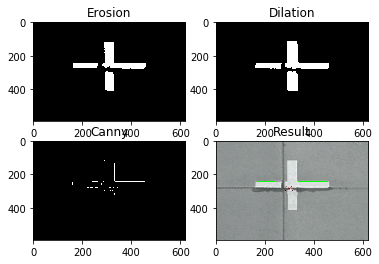

=======垂直======= [270.0, 277.0, 269.0, 269.0, 277.0, 268.0] =============
=======水平======= [282.0, 276.0, 279.0, 278.0, 276.0, 284.0] =============
272.5 280.0


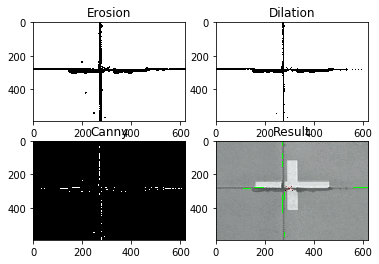

In [77]:
# img=cv2.imread('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg')
# img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# #降造(高斯平滑)
# img_blurred=cv2.GaussianBlur(img_gray,(3,3),0)

# #reload原圖
# og_img=cv2.imread('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg')

# #二值化取mark (二值化閥水平)
# thresh_mark=180
# mark_bin=cv2.threshold(img_blurred,thresh_mark,255,cv2.THRESH_BINARY)[1]
# cv2.imwrite('C://Users//2102048//pythonCV//find_cut//cut_result//mark_01.jpg',mark_bin)
# mark_x,mark_y=line(mark_bin,img,'C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg','C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\','mark',1)

# img=cv2.imread('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg')

# thresh_cut=130
# cut_bin=cv2.threshold(img_blurred,thresh_cut,255,cv2.THRESH_BINARY)[1]
# cv2.imwrite('C://Users//2102048//pythonCV//find_cut//cut_result//cut_01.jpg',cut_bin)
# cut_x,cut_y=line(cut_bin,img,'C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg','C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\','cut',1)


# #取影像大小，設定取霍夫曼區域
# c_column,c_row,color=img.shape
# ##################影像前處理###########################
# # Erosion 影像侵蝕(二值化後)
# kernel = np.ones((3,3), np.uint8)
# erosion = cv2.erode(mark_bin, kernel, iterations = 3)

# # #Dilation 影像膨脹(二值化後)
# kernel = np.ones((3,3), np.uint8)
# dilation = cv2.dilate(erosion, kernel, iterations = 3) #執行越多次膨脹效果越明顯
# blur= cv2.GaussianBlur(dilation, (5, 5), 0) # 用高斯平滑處理原影象降噪 
# #canny邊緣檢測
# canny = cv2.Canny(blur, 40, 120) #low_threshold:40, high_threshold:120
# cv2.imwrite('C://Users//2102048//pythonCV//find_cut//cut_result//Canny_001_01.jpg',canny)
# plt.imshow(canny,cmap='gray')
# plt.title('test')
# plt.show()

# #######################
# #直線檢測--霍夫直線變換

# #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
# lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=1) #霍夫直線變換
# lines1 = lines[:, 0, :]  # 提取為二維
# for x1, y1, x2, y2 in lines1[:]:
#     if (((0<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column))):
#         cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

# cv2.imwrite('C://Users//2102048//pythonCV//find_cut//cut_result//Hough_001_01.jpg',img)

# i=1
# vline=[]
# hline=[]
# for line in lines:
#     '''
#     print("line["+str(i-1)+"]=",line)
#     '''
#     x1,y1,x2,y2 = line[0] 

#     x1 = float(x1)
#     x2 = float(x2)
#     y1 = float(y1)
#     y2 = float(y2)
#     '''
#     print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
#     '''
#     if ((x2 - x1 == 0 )and(((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):

#         result=90
#         #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
#         vline.append(x1)
#     #判斷水平線&定義的範圍
#     elif ((y2 - y1 == 0) and (((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):
#         result=0
#         hline.append(y1)
#     i = i+1
# #mark水平線異常處理

# print("=======垂直=======",vline,"=============")
# print("=======水平=======",hline,"=============")

## 步驟四，計算角落

In [84]:
#參數(照片角落順序,輸入路徑,輸出路徑,要不要顯示影像)
def Image_processing_calculation(order,input_path,output_path,control):
    #input_path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_temp\\'
    #output_path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_result\\'
    try:
        #######################塞值###############################
        #initialize
        point_1=0
        point_2=0
        point_3=0
        point_4=0
        point_5=0
        point_6=0
        point_7=0
        point_8=0
        #放8個點位置
        point_dic={'sheet_id':[],
                   'point_1':[],
                   'point_2':[],
                   'point_3':[],
                   'point_4':[],
                   'point_5':[],
                   'point_6':[],
                   'point_7':[],
                   'point_8':[],
                   'check':[],
                  }
        #將字典做成表格
        point_table=pd.DataFrame(point_dic)
        #角落參數
        corner_list=['Bottom_left_corner','Bottom_right_corner','Upper_left_corner','Upper_right_corner']
        #######################塞值###############################


        #input_path=f
        #name=os.path.basename(input_path)
        #讀檔案原檔
        img=cv2.imread(input_path)

        #算長寬
        height,width,color=img.shape
        #灰階
        img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #降造(高斯平滑)
        img_blurred=cv2.GaussianBlur(img_gray,(3,3),0)
        #將處理完的矩陣塞進去
        table_gray=pd.DataFrame(img_blurred.reshape(height,width))
        #table_gray.to_csv(output_path+'blurred.csv')

        #reload原圖
        og_img=cv2.imread(input_path)

        #二值化取mark (二值化閥水平)
        thresh_mark=180
        mark_bin=cv2.threshold(img_blurred,thresh_mark,255,cv2.THRESH_BINARY)[1]
        cv2.imwrite(output_path +'Thresh_mark'+'001.jpg', mark_bin)
        #print("=================霍夫曼取直線(mark)=======================")
        #霍夫曼取直線(mark)，參數(二值化圖,原圖,in,out,存檔名,要不要顯示)
        mark_x,mark_y=line(mark_bin,img,input_path,output_path,'mark',1)
        #print(mark_x,mark_y)


        #二值化取cut (二值化閥水平)
        thresh_cut=130
        cut_bin=cv2.threshold(img_blurred,thresh_cut,255,cv2.THRESH_BINARY)[1]
        cv2.imwrite(output_path +'Thresh_cut'+'001.jpg', cut_bin)
        #print("=================霍夫曼取直線(cut)=======================")
        #霍夫曼取直線(cut)，參數(二值化圖,原圖,in,out,存檔名,要不要顯示)
        cut_x,cut_y=line(cut_bin,og_img,input_path,output_path,'cut',1)
        #print(cut_x,cut_y)

        #輸出角落結果
        print("====",corner_list[order],"====")
        if cut_x>0 and cut_y>0 and mark_x>0 and mark_y>0:
            #print("========================================")
            #print('x切割精度:{} pixel, y切割精度:{} pixel'.format(abs(mark_x-cut_x),abs(mark_y-cut_y)))
            #分角落
            if order==0:
                point_5=abs(mark_x-cut_x)
                point_4=abs(mark_y-cut_y)
                step_dic={ 
                           'point_5':[point_5],
                           'point_4':[point_4],
                         }

            if order==1:

                point_6=abs(mark_x-cut_x)
                point_7=abs(mark_y-cut_y)
                step_dic={ 
                           'point_6':[point_6],
                           'point_7':[point_7],
                         }

            if order==2:
                point_2=abs(mark_x-cut_x)
                point_3=abs(mark_y-cut_y)
                step_dic={ 
                           'point_2':[point_2],
                           'point_3':[point_3],
                         }

            if order==3:
                point_1=abs(mark_x-cut_x)
                point_8=abs(mark_y-cut_y)
                step_dic={ 
                           'point_1':[point_1],
                           'point_8':[point_8],
                         }
            step_table=pd.DataFrame(step_dic)
            #合併dataframe(新增時忽略index欄位，並不要排序)
            point_table=point_table.append(step_table,ignore_index=True,sort=False)
            #轉換行跟列，方便計算
            transpose= point_table.T
            #把null的值都補上0
            transpose_point_table=transpose.where(transpose.notnull(),0)
            return transpose_point_table

        ##換算pixel的倍率

        else:
            print("Error 數值有負，計算錯誤")
            return 0
    except:
        print("Image_processing_calculation ERROR")
        return 0
    finally:
        if control==1:
            titles=['original','blurred','bin_mark','bin_cut']
            images=[img_gray,img_blurred,mark_bin,cut_bin]
            for i in range(4):
                #row*column
                plt.subplot(2,2,i+1)
                plt.imshow(images[i],'gray')
                plt.title(titles[i])
            plt.show()
        

## Test

=======垂直======= [330.0, 289.0, 288.0, 331.0] =============
=======水平======= [242.0, 280.0, 243.0, 277.0] =============
309.5 261.0


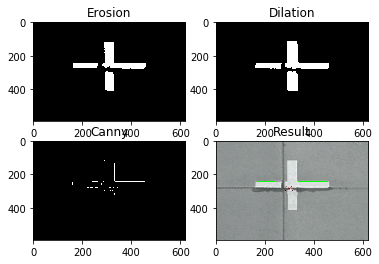

=======垂直======= [270.0, 277.0, 269.0, 269.0, 277.0, 268.0] =============
=======水平======= [282.0, 276.0, 279.0, 278.0, 276.0, 284.0] =============
272.5 280.0


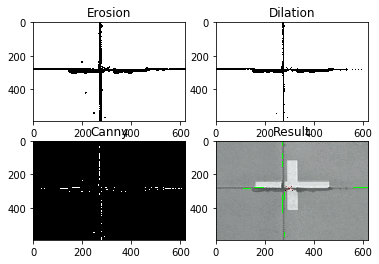

==== Bottom_right_corner ====


,0
sheet_id,0.0
point_1,0.0
point_2,0.0
point_3,0.0
point_4,0.0
point_5,0.0
point_6,37.0
point_7,19.0
point_8,0.0
check,0.0


In [82]:
# Image_processing_calculation(1,'C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg','C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\',0)

## 步驟五:換算真實座標

In [7]:
#換算距離成真實數值
def real_measure(table,output_path,name):
    #放8個點位置
    point_dic={'sheet_id':[],
                'point_1':[],
                'point_2':[],
                'point_3':[],
                'point_4':[],
                'point_5':[],
                'point_6':[],
                'point_7':[],
                'point_8':[],
                'check':[],
              }
    point_table=pd.DataFrame(point_dic)
    #轉置
    transpose=point_table.T
    #取size
    c_row,c_column=table.shape
    #取欄位
    point_1=table.iloc[1,0]
    point_2=table.iloc[2,0]
    point_3=table.iloc[3,0]
    point_4=table.iloc[4,0]
    point_5=table.iloc[5,0]
    point_6=table.iloc[6,0]
    point_7=table.iloc[7,0]
    point_8=table.iloc[8,0]
    
    #開始換算
    stendard=400
    if point_1>0:
        point_1=stendard+(point_1*3.8637)
    if point_2>0:
        point_2=stendard+(point_2*4.4899)
    if point_3>0:
        point_3=stendard+(point_3*4.1998)
    if point_4>0:
        point_4=stendard+(point_4*4.3048)
    if point_5>0:
        point_5=stendard+(point_5*4.2021)
    if point_6>0:
        point_6=stendard+(point_6*4.5211)
    if point_7>0:
        point_7=stendard+(point_7*3.3411)
    if point_8>0:
        point_8=stendard+(point_8*3.3984)
    
    real_point_dic={
                    "point_1":[point_1],
                    "point_2":[point_2],
                    "point_3":[point_3],
                    "point_4":[point_4],
                    "point_5":[point_5],
                    "point_6":[point_6],
                    "point_7":[point_7],
                    "point_8":[point_8],
                    }
    real_point_table=pd.DataFrame(real_point_dic)
    transform=real_point_table.T
    
    
    print("=========real===========")
    print(transform)
    transform.to_csv(output_path+'result_'+name+'.csv')
    return(transform)

## 步驟六:使用步驟4、5分角落塞值

In [88]:
def x_ray_cutting(input_path,output_path):
    total_dic={'sheet_id':[0],
                               'point_1':[0],
                               'point_2':[0],
                               'point_3':[0],
                               'point_4':[0],
                               'point_5':[0],
                               'point_6':[0],
                               'point_7':[0],
                               'point_8':[0],
                               'check':[0],
                    }
    total_table=pd.DataFrame(total_dic)
    #轉換行跟列，方便計算
    transpose= total_table.T
    #空值補0
    transpose_total_table=transpose.where(transpose.notnull(),0)
    #流水號
    number=1


    #using function(input,output,要不要顯示圖)
#     path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_temp\\'
#     output_path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_result\\'
    file=glob.glob(input_path+'*.jpg')
    for i,f in enumerate(file):
        #using function(角落順序,影像路徑,輸出路徑,要不要顯示)
        label_table=Image_processing_calculation(i,f,output_path,0)
        #計算出數值有錯回傳int
        if type(label_table)==int:
            print('Image_processing_calculation error')
        #都有數值
        else:
            #修改欄位名稱(方便後面相加的時候識別)
            label_table.columns=[1]
            #相加
            #print("========================================")

            #連接兩個字典
            df_result=pd.concat([transpose_total_table,label_table],axis=1,ignore_index=False)
            #原本的表格加上新增的表格
            df_result[0]=df_result[0]+df_result[1]
            #刪除新增的欄
            df_result.pop(1)
            #將存好的table存到外面
            transpose_total_table = df_result

    
    #存csv
    transpose_total_table.to_csv(output_path+'pixel_'+str('{:0>3d}').format(number)+'.csv')
    print(transpose_total_table)
    #換算成真實值
    #(pixel的table,存檔路徑,檔名)
    real_table=real_measure(transpose_total_table,output_path,str('{:0>3d}').format(number))
                
    #刪除資料夾
    #整個刪掉在建立新的
    shutil.rmtree(input_path)
    os.mkdir(input_path)




## 參數調整test

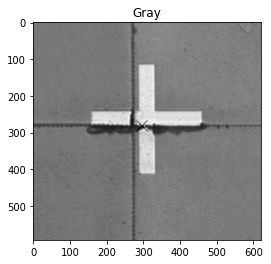

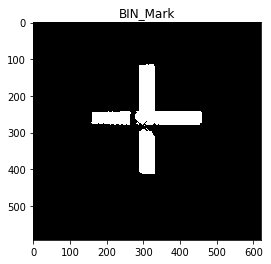

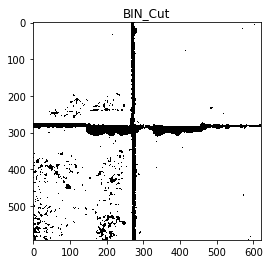

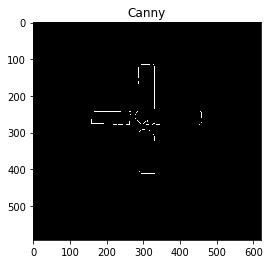

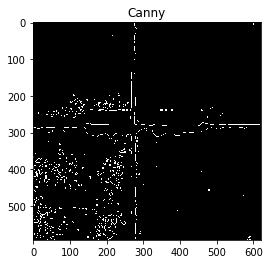

===== 621 ===== 593


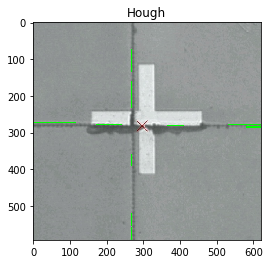

=====V_line_list===== [267.0, 268.0, 269.0, 269.0, 269.0]
=====H_line_list===== [274.0, 278.0, 278.0, 279.0, 282.0, 285.0]
===== 621 ===== 593


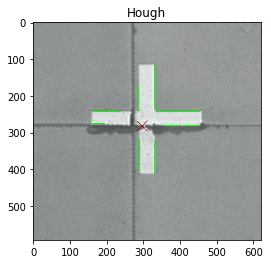

=====V_line_list===== [288.0, 289.0, 330.0, 331.0]
=====H_line_list===== [242.0, 243.0, 276.0, 277.0, 280.0, 280.0]


In [20]:
#=================第三階段改參數============================
#處理完的canny圖
def step3_test(canny,Im,name):
#直線檢測--霍夫直線變換
    c_column,c_row,color=Im.shape
    print('=====',c_row,"=====",c_column)

    
    #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
    lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=1) #霍夫直線變換
    lines1 = lines[:, 0, :]  # 提取為二維
    for x1, y1, x2, y2 in lines1[:]:
        if (((0<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column))):
            cv2.line(Im, (x1, y1), (x2, y2), (0, 255, 0), 2)

    #存檔霍夫曼結果
    cv2.imwrite('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\' +'Result_H'+name+'.jpg',Im)
    plt.imshow(Im,cmap='gray')
    plt.title('Hough')
    plt.show()

    #判斷斜率
    vline=[]
    hline=[]
    # 對通過霍夫變換得到的資料進行遍歷
    for line in lines:

        x1,y1,x2,y2 = line[0] 
        x1 = float(x1)
        x2 = float(x2)
        y1 = float(y1)
        y2 = float(y2)

        #判斷垂直線&定義的範圍
        if ((x2 - x1 == 0 )and(((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):
            result=90
            #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
            vline.append(x1)
        #判斷水平線&定義的範圍

        elif ((y2 - y1 == 0) and (((10<x1<c_row)or(10<x2<c_row))and((10<y1<c_column)or(10<y2<c_column)))):
            result=0
            #記錄所有水平線的y座標，最大-最小得出水平線之間的距離
            hline.append(y1)   


    #mark水平線異常處理
    if name=='mark':
        temp=min(hline)
        temp+=35
        hline.append(temp)
    
    print('=====V_line_list=====', sorted(vline))
    print('=====H_line_list=====',sorted(hline))


#=================第二階段改參數============================
def step2_test(img,name):
    # Erosion 影像侵蝕(二值化後)
    kernel = np.ones((3,3), np.uint8)
    erosion = cv2.erode(img, kernel, iterations = 2)

    # #Dilation 影像膨脹(二值化後)
    kernel = np.ones((3,3), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations = 2) #執行越多次膨脹效果越明顯
    dilation= cv2.GaussianBlur(dilation, (5, 5), 0) # 用高斯平滑處理原影象降噪 
    #canny邊緣檢測
    canny = cv2.Canny(dilation, 50, 130) #low_threshold:30, high_threshold:150
    
    cv2.imwrite('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\' +'Result_'+name+'.jpg',canny)
    plt.imshow(cv2.cvtColor(canny,cv2.COLOR_GRAY2RGB))
    plt.title('Canny')
    plt.show()
    
    return canny

def step1_test(input_path):
    img=cv2.imread(input_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale conversion
    blurred = cv2.GaussianBlur(gray, (5, 5), 0) # 用高斯平滑處理原影象降噪 

    #=================第一階段感參數============================
    #灰階
    plt.imshow(blurred,cmap='gray')
    plt.title('Gray')
    plt.show()
    #二值化，留Mark
    thresh = 180
    mark_Bin= cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1] 
    plt.imshow(mark_Bin,cmap='gray')
    plt.title('BIN_Mark')
    plt.show()
    cv2.imwrite('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\' +'Preprocess_mark.jpg',mark_Bin)
    
    #二值化，留切割
    thresh = 140
    cut_Bin = cv2.threshold(blurred, thresh, 255, cv2.THRESH_BINARY)[1] 
    plt.imshow(cut_Bin,cmap='gray')
    plt.title('BIN_Cut')
    plt.show()
    cv2.imwrite('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\' +'Preprocess_cut.jpg',cut_Bin)
    
    canny_mark=step2_test(mark_Bin,'mark')
    canny_cut=step2_test(cut_Bin,'cut')
    
    step3_test(canny_cut,img,'cut')
    img=cv2.imread(input_path)
    step3_test(canny_mark,img,'mark')
#step1_test('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\001_01.jpg')

## reset 資料夾

In [93]:
def resetfile(path):
    #刪除資料夾
    #整個刪掉在建立新的
    shutil.rmtree(path)
    os.mkdir(path)

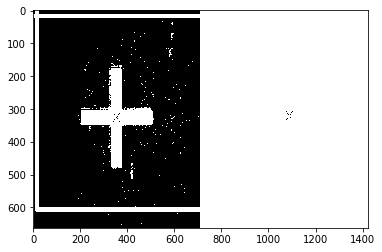

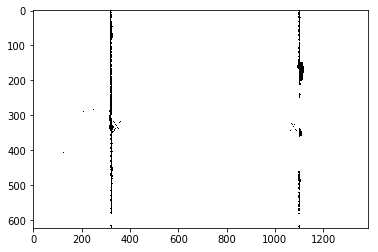

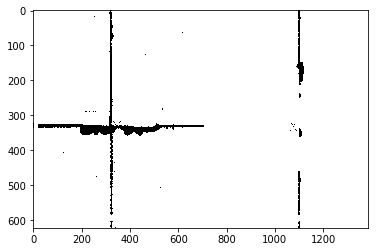

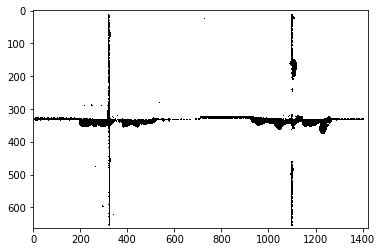

C:\Users\2102048\pythonCV\find_cut\temp\001.jpg
one 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\find_cut\\Screen\\one\\Target_2021-06-01 171152.092249.jpg']


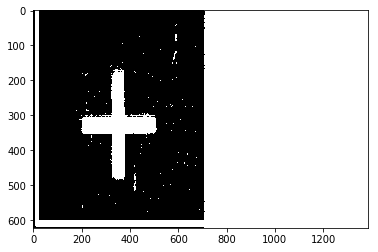

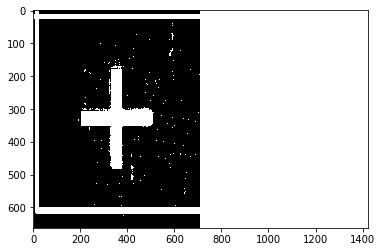

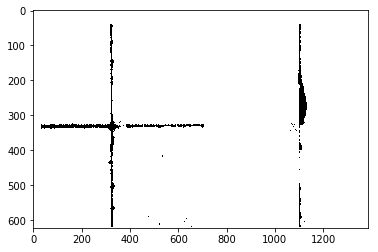

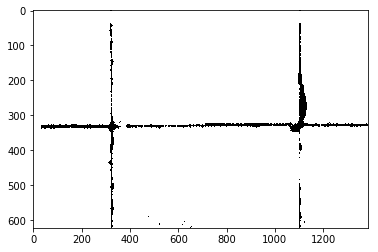

C:\Users\2102048\pythonCV\find_cut\temp\002.jpg
two 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\find_cut\\Screen\\two\\Target_2021-06-01 171201.958267.jpg']
分割OK
=======垂直======= [330.0, 289.0, 288.0, 331.0] =============
=======水平======= [242.0, 280.0, 243.0, 277.0] =============
309.5 261.0


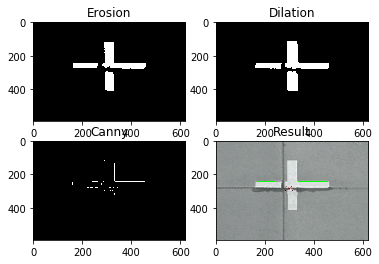

=======垂直======= [270.0, 277.0, 269.0, 269.0, 277.0, 268.0] =============
=======水平======= [282.0, 276.0, 279.0, 278.0, 276.0, 284.0] =============
272.5 280.0


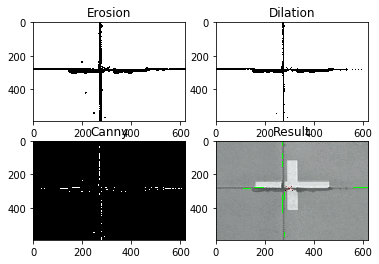

==== Bottom_left_corner ====
=======垂直======= [345.0, 312.0, 311.0, 357.0] =============
=======水平======= [238.0, 239.0, 273.0] =============
334.0 255.5


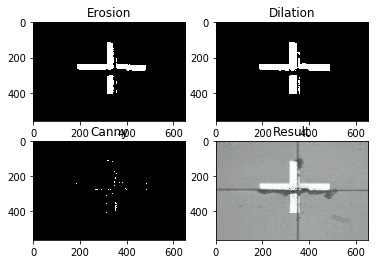

=======垂直======= [345.0, 351.0, 351.0] =============
=======水平======= [278.0, 272.0, 284.0] =============
348.0 278.0


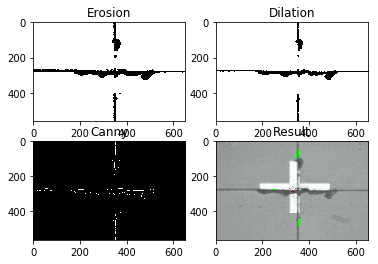

==== Bottom_right_corner ====
=======垂直======= [291.0, 334.0, 333.0, 290.0] =============
=======水平======= [332.0, 288.0, 333.0, 290.0, 323.0] =============
312.0 310.5


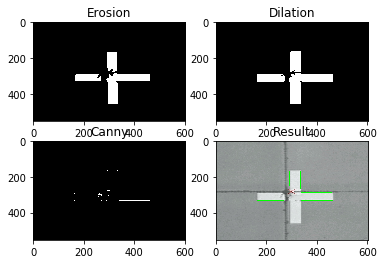

=======垂直======= [270.0, 271.0, 276.0, 271.0] =============
=======水平======= [278.0, 278.0, 287.0, 283.0, 278.0] =============
273.0 282.5


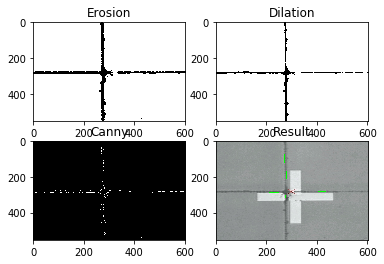

==== Upper_left_corner ====
=======垂直======= [334.0, 366.0, 366.0] =============
=======水平======= [286.0, 331.0, 286.0, 321.0] =============
350.0 308.5


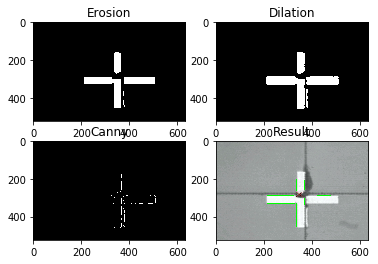

=======垂直======= [368.0, 373.0] =============
=======水平======= [273.0, 274.0, 282.0, 273.0, 272.0, 273.0] =============
370.5 277.0


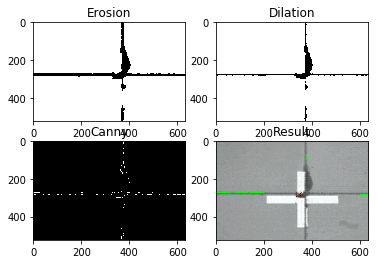

==== Upper_right_corner ====
             0
sheet_id   0.0
point_1   20.5
point_2   39.0
point_3   28.0
point_4   19.0
point_5   37.0
point_6   14.0
point_7   22.5
point_8   31.5
check      0.0
=========real===========
                 0
point_1  479.20585
point_2  575.10610
point_3  517.59440
point_4  481.79120
point_5  555.47770
point_6  463.29540
point_7  475.17475
point_8  507.04960


In [87]:
# #過濾
# use_find_CuttingLine('C:\\Users\\2102048\\pythonCV\\find_cut\\Screen\\','C:\\Users\\2102048\\pythonCV\\find_cut\\temp')
# time.sleep(1)
# #分邊
# precutting('C:\\Users\\2102048\\pythonCV\\find_cut\\temp\\','C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\')
# time.sleep(1)
# #計算
# x_ray_cutting('C:\\Users\\2102048\\pythonCV\\find_cut\\cut_temp\\','C:\\Users\\2102048\\pythonCV\\find_cut\\cut_result\\')

In [9]:
def test_function():
    print("===ok===")